In [1]:
from RooPandasFunctions import PSequential,PColumn,PFilter,PRow,PProcessor,PProcRunner,PInitDir
import pandas as pd
from glob import glob
from ROOT import TH1F,TH2F,TLorentzVector,TFile,TCanvas,TLegend,gPad
from collections import OrderedDict
import numpy as np
import copy
import pyarrow as pa

Welcome to JupyROOT 6.22/00


In [2]:
#PInitDir parses a directory created at nanoaod conversion time.  It creates dataset and file lists to be used by the processor
chunklist = PInitDir("RooFlatFull")

In [3]:
#Histograms are stored as a dict, and accessed through matching dict keys and DataFrame labels
histostemp=OrderedDict  ([
                        ("invm",TH1F("invm","invm",100,0,5000)),
                        ("fjpt",TH1F("fjpt","fjpt",100,0,2000)),
                        ("fjeta",TH1F("fjeta","fjeta",100,0,2.4)),
                        ("njettight",TH1F("njettight","njettight",100,200,3500)),
                        ("njetloose",TH1F("njetloose","njetloose",100,200,3500)),
                        ("dijetht",TH1F("dijetht","dijetht",100,200,3500)),
                        ("ht20",TH1F("ht20","ht20",100,200,3500)),
                        ("ht02",TH1F("ht02","ht02",100,200,3500)),
                        ("ht11",TH1F("ht11","ht11",100,200,3500)),
                        #2D histogram.  parse variables with a "__" delimeter
                        ("tight90pt1__tight90pt1MSE",TH2F("tight90pt1__tight90pt1MSE","tight90pt1__tight90pt1MSE",100,0,2000,80,-14,-6)),
                        ("fjpt__fjeta",TH2F("fjpt__fjeta","fjpt__fjeta",100,0,2000,100,0,2.4)),
                        ("njettight__njetloose",TH2F("njettight__njetloose","njettight__njetloose",4,-0.5,3.5,4,-0.5,3.5))
                        ])
for hist in histostemp:
    histostemp[hist].Sumw2() 

In [4]:
#This takes the histograms and makes a copy for each dataset
histos= {}
for ds in chunklist:
    histos[ds]=copy.deepcopy(histostemp)

In [5]:
#The analysis uses PColumn,PFilter, and PRow actions which all take in a python function as an argument and use it 
#to efficiently analyze a DataFrame.

#Here are some functions that will later be used as input to these actions

In [6]:
#PFilter -- can be a function or class with a __call__ method
class KinematicSelection():
    def __init__(self,ptcut,msdcut):
        self.ptcut=ptcut
        self.msdcut=msdcut
    def __call__(self,df,EventInfo):
        #Kinematic filter operation.  For safety, the event-level filtering should only occur through the PFilter function.
        #This takes in a bool Series with one truth value per event.  This is very fast, and should be performed before any slower actions.
        #print(df["FatJet"])

        #njetcut is a elementwise selection used as  input to C1.  If you want to use this as an event filter, add [:,0] like in HLT selection below
        njetcut=df["FatJet"]["nFatJet"]>1


        #print(df["FatJet"])
        #passing None out of Filter will skip the entire current file (to avoid index errors)
        if (not njetcut.any()):
            return None
        #print(df["FatJet"]["pt"][njetcut])
        C1=((df["FatJet"]["pt"][njetcut][:,0]>self.ptcut) & (df["FatJet"]["pt"][njetcut][:,1]>self.ptcut) & (df["FatJet"]["msoftdrop"][njetcut][:,0]>self.msdcut) & (df["FatJet"]["msoftdrop"][njetcut][:,1]>self.msdcut))

        #Triggers are already stored as bools
        C2=df["HLT"]["PFHT900"][:,0]
        if (not (C1 & C2).any()):
            return None

        return ( C1 & C2 )

In [7]:
#PColumn function  
class ColumnSelectionPre():
    def __call__(self,df,EventInfo):
        #Examples of columnwise actions. 
        #We can define a new collection variable (one item per entry).  Here we make fatjet et out of pt and mass
        df["FatJet"]["Et"]=np.sqrt(df["FatJet"]["pt"]*df["FatJet"]["pt"]+df["FatJet"]["mass"]*df["FatJet"]["mass"])
        df["Hists"]["Et"] = df["FatJet"]["Et"][:,0]

        #this creates the generic histrogram weights by taking the event weight and projecting to the event size
        ptcut=df["FatJet"]["pt"]>200.
        dfsel=df["FatJet"][ptcut]
        cut90,cut99,cut999=-11.3,-9.9,-9.2
        
        
        logmse=np.log(dfsel["iAEMSE"])
        njettight=((logmse>cut90).sum(level=0))
        njetloose=((logmse<cut90).sum(level=0))
        
        df["Hists"]["njettight"]=njettight
        df["Hists"]["njetloose"]=njetloose
        
        df["Hists"]["ht"]=dfsel["pt"].sum(level=0)
        df["Hists"]["njettight"] = njettight
        df["Hists"]["njetloose"] = njetloose
        df["Hists"]["ht11"]=df["Hists"]["ht"][(df["Hists"]["njettight"]==1)&(df["Hists"]["njetloose"]==1)]
        df["Hists"]["ht20"]=df["Hists"]["ht"][(df["Hists"]["njettight"]==2)&(df["Hists"]["njetloose"]==0)]
        df["Hists"]["ht02"]=df["Hists"]["ht"][(df["Hists"]["njettight"]==0)&(df["Hists"]["njetloose"]==2)]

        #make sure there are any events left
        if len(njettight)>0:
            df["Hists"]["tight90pt1"] = dfsel["pt"][logmse>cut90][:,0]
            df["Hists"]["tight90pt1MSE"] = logmse[logmse>cut90][:,0]
            #print(dfsel["pt"][logmse>cut90])
            #print(dfsel["pt"][logmse>cut90].groupby(level=0).size())
        if len(njetloose)>0:
            df["Hists"]["loose90pt1"] = dfsel["pt"][logmse<cut90][:,0]

        EventInfo.eventcontainer["evweight"] = EventInfo.eventcontainer["lumi"]*EventInfo.eventcontainer["xsec"][EventInfo.dataset]/EventInfo.eventcontainer["nev"][EventInfo.dataset]



        #the  "weight" specific key will be used to weight all histograms unless there exists a histname__weight entry in the "Hists" dict
        #It is initialized as 1, so additional weights are multiplicative 
        df["Hists"]["weight"] *= EventInfo.eventcontainer["evweight"]
        df["Hists"]["Et"] = df["FatJet"]["Et"][:,0]
        df["Hists"]["logMSE_all"] = np.log(df["FatJet"]["iAEMSE"])

        return df

In [8]:
#one way to set the weights.  In general, each histogram needs a corresponding weights.
#Until we have all weights, we  just project the event weights to each histogram.
#You can skip this step and it will be done at histogram filling time automatically, but will be much slower and print a warning
#Probably need to find a better way to do this 
class ColumnWeights():
    def __call__(self,df,EventInfo):
        keys=list(df["Hists"].keys())
        for hh in keys:
            if hh in ["invm__logMSE","fjpt__fjeta","njettight__njetloose","event","weight"]:
                continue
            df["Hists"][hh+"__weight"]=df["Hists"]["weight"]
            if (df["Hists"][hh].index.nlevels > df["Hists"]["weight"].index.nlevels )  :
                df["Hists"][hh]=df["Hists"][hh].droplevel(level=1)
            df["Hists"][hh+"__weight"] = df["Hists"][hh+"__weight"][df["Hists"][hh+"__weight"].index.isin(df["Hists"][hh].index)]
        df["Hists"]["invm__logMSE__weight"]=df["Hists"]["invm__weight"]
        return df

In [9]:
#PColumn function
class ColumnSelection():
    def __call__(self,df,EventInfo):
        #Examples of columnwise actions. 
        #We can define a new collection variable (one item per entry).  Here we make fatjet et out of pt and mass
        df["FatJet"]["Et"]=np.sqrt(df["FatJet"]["pt"]*df["FatJet"]["pt"]+df["FatJet"]["mass"]*df["FatJet"]["mass"])



        #We can store the leading two jet ht (one item per event) the "" collection is a key used for event-level info
        #print(df["FatJet"]["pt"])
        df[""]["dijetht"] = df["FatJet"]["pt"][:,0]+df["FatJet"]["pt"][:,1]    
        df["Hists"]["dijetht"] = df[""]["dijetht"]
        #We can also define variables for plotting.  Here, deta refers to the histogram above. 
        #The "Hists" collection is special, and holds all variables visible to the histogram filling
        df["Hists"]["deta"] = np.abs(df["FatJet"]["eta"][:,0]-df["FatJet"]["eta"][:,1])  
        df["Hists"]["pt"] = df["FatJet"]["pt"][:,0]  
        #Here is an example of a many-to-one operation where we loop through muons to find the closest (in eta) to the leading AK8 jet
        
        njets=df["Muon"].index.get_level_values(1).max()+1 #index+1 is number of objects 
        for ii in range(njets):
            curdiff=(np.abs(df["FatJet"]["eta"][:,0]-df["Muon"]["eta"][:,ii]))
            if ii==0:
                temp=curdiff
            else:
                temp=pd.concat([temp,curdiff],axis=1)
        df["Hists"]["mindetaak4"] = temp.min(axis=1)

        #df["Hists"]["weight"] *= EventInfo.eventcontainer["evweight"]
        #print(df["Hists"]["weight"])
        #You can also drop unused columns at any time -- here we drop the  pt,eta,phi,mass columns from the fatjet collection 
        #because we have stored the lorentzector already
        df["FatJet"] = df["FatJet"].drop(["pt","eta","phi","mass"],axis=1)
        return df

In [10]:
#PRow functions.  
#These are classes where the __call__ special function is performed in a rowwise loop
class MakePtEtaPhiMLV():
    #Example of a rowwise action.  These are slower than the columnwise selections, so best to do them last.
    #These are also much more general though, so likely they will be required.
    #These use the PRow() action which is a wrapper for the fastest method that I could find.
    #First, define your preprocessing steps so that you only consider the minimal number of columns
    def prepdf(self,df):
        args = [df["FatJet"]["pt"],df["FatJet"]["eta"],df["FatJet"]["phi"],df["FatJet"]["mass"]]
        return args

    #The args are then passed to the call function 
    def __call__(self,args,EventInfo):
        #Here, you can write general code as if you were acting on elements and not columns
        #This just takes pt,eta,phi, and mass and converts to a four vector,  This will be saved in the DataFrame and column passed below
        (pt,eta,phi,mass)=args
        LV=TLorentzVector()

        LV.SetPtEtaPhiM(pt,eta,phi,mass)
        return LV

In [11]:
class MyAnalyzerVec():
    #Another example of a rowwise action.  This will be likely replaced with the full analysis logic.
    #Here, we prepare the leading two jet invariant mass and MSE for plotting
    def prepdf(self,df):
        args = [df["FatJet"]["LV"][:,0],df["FatJet"]["LV"][:,1],df["FatJet"]["iAEMSE"][:,0]] 
        return args
    def __call__(self,args,EventInfo):
        (LV0,LV1,MSE)=args
        invm=(LV0 + LV1).M() 

        #This is where I can access the fake MSE shift object that was passed to the processor below
        msescale=EventInfo.eventcontainer["msescale"][EventInfo.dataset]

        return (invm,np.log(MSE),np.log(MSE*msescale))

In [12]:
#Dict of collections and variables to read in.
branchestoread={
                "Muon":["pt","eta","phi","mass"],
                "FatJet":["pt","eta","phi","mass","msoftdrop","iAEMSE"],
                "HLT":["PFHT900"],
                "":["run","luminosityBlock","event"]
                }
#Hacky, specifies which branches are single valued per event
scalars=["","HLT"]

In [13]:
#The analysis is defined here as a sequential list of actions
myana=  [
        PColumn(ColumnSelectionPre()),
        #PFilter just takes in a function that outputs a series of bools
        PFilter(KinematicSelection(200.,50.)),
        #PRow takes in two elements.  
        #The first describes the output collections and variables and the second is the function that will deliver them
        PRow([["FatJet","LV"]],MakePtEtaPhiMLV()),
        #PColumn just takes in a function that outputs a new dataframe
        PColumn(ColumnSelection()),
        #The collection here is "Hists" so we can plot these variables 
        PRow([["Hists","invm"],["Hists","logMSE"],["Hists","logMSEshift"]],MyAnalyzerVec()),
        PColumn(ColumnWeights()),
        ]

In [14]:
#Every action receives the "EventInfo" object.  This contains any state information (like current dataset or number of events processed)
#But also, you can pass anthing you want as well through the eventcontainer.  
#Here we pass some hypothetical dataset dependent MSE shift as an example.
#Also, objects can be passed through the class __init__ for each function  
evcont={"msescale":{"TT":1.10,"QCD_HT1500to2000":0.9},"lumi":(1000.0*137.65),"xsec":{"TT":0.047,"QCD_HT1500to2000":101.8},"nev":{"TT":305963.0,"QCD_HT1500to2000":10655313.0}}

In [15]:
#The processor just takes in all the peices

proc=PProcessor(chunklist,histos,branchestoread,myana,eventcontainer=evcont,atype="flat",scalars=scalars)
#Multiprocessor
Mproc=PProcRunner(proc,6)
#Then runs them
returndf=Mproc.Run()

Running process over 6 processors


Dataset:QCD_HT1500to2000 Process:4: 100%|██████████| 7/7 [00:22<00:00,  3.23s/it]


Done
Fill Hist


/cms/daj111/autoencoder/CMSSW_11_3_3/src/AEAnalyzer/RooPandasFunctions.py:168: UserWarning: Warning: Attempting to project weights for histogram, this should be done in the analyzer
  warnings.warn("Warning: Attempting to project weights for histogram, this should be done in the analyzer")


tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
tight90pt1__tight90pt1MSE
njettight__njetloose
Timing...
	 Start 0.0
	 File Read 0.2188854217529297
	 Parsed 0.3826580047607422
	 Analyzed 2.6417388916015625
Dataset: TT Completed
Events input: 508484 output: 333882
Timing...
	 Start 0.0
	 File Read 1.8280048370361328
	 Parsed 5.798862457275391
	 Analyzed 21.96046257019043
Dataset: QCD_HT1500to2000 Completed
Events input: 9361512 output: 1354691
Done
Total time 48.47024750709534


In [16]:
for rr in returndf:
    print  (rr ,"cut90",returndf[rr]["logMSE_all"].quantile(0.9))
    print  (rr ,"cut99",returndf[rr]["logMSE_all"].quantile(0.99))
    print  (rr ,"cut999",returndf[rr]["logMSE_all"].quantile(0.999))

TT cut90 -10.116385
TT cut99 -9.211964
TT cut999 -8.743546
QCD_HT1500to2000 cut90 -11.281307
QCD_HT1500to2000 cut99 -9.906904
QCD_HT1500to2000 cut999 -9.161895


In [17]:
#Finally, write out the histograms
output = TFile("FromFlatPandas.root","recreate")
output.cd()
for ds in histos:
    for var in histos[ds]:
            histos[ds][var].Write(ds+"__"+var)
output.Close()

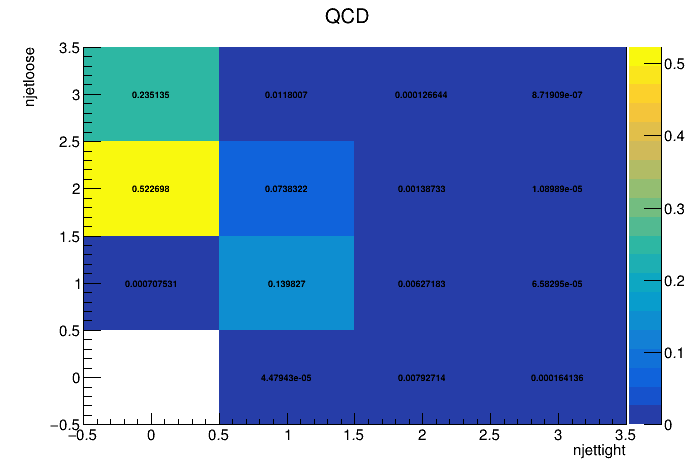

In [18]:
canv=TCanvas("canv","canv",700,500)
gPad.SetLeftMargin(0.12)
histos["QCD_HT1500to2000"]["njettight__njetloose"].SetTitle("QCD;njettight;njetloose")
histos["QCD_HT1500to2000"]["njettight__njetloose"].SetStats(0)
norm = 1/histos["QCD_HT1500to2000"]["njettight__njetloose"].Integral()
histos["QCD_HT1500to2000"]["njettight__njetloose"].Scale(norm)
histos["QCD_HT1500to2000"]["njettight__njetloose"].Draw("colztext")
canv.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


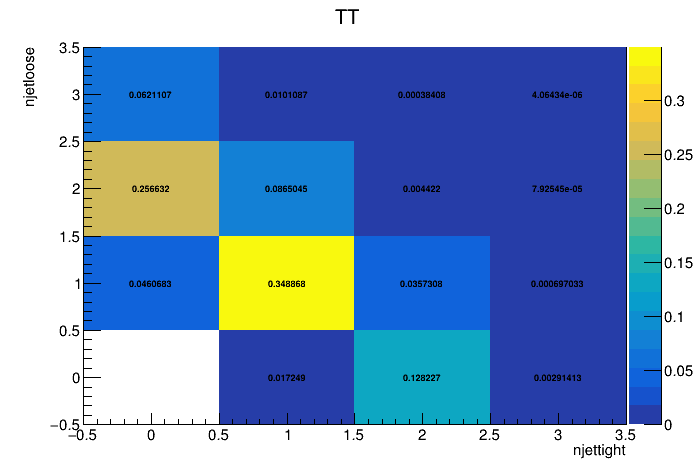

In [19]:
canv=TCanvas("canv","canv",700,500)
gPad.SetLeftMargin(0.12)
histos["TT"]["njettight__njetloose"].SetTitle("TT;njettight;njetloose")
histos["TT"]["njettight__njetloose"].SetStats(0)
norm = 1/histos["TT"]["njettight__njetloose"].Integral()
histos["TT"]["njettight__njetloose"].Scale(norm)
histos["TT"]["njettight__njetloose"].Draw("colztext")
canv.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


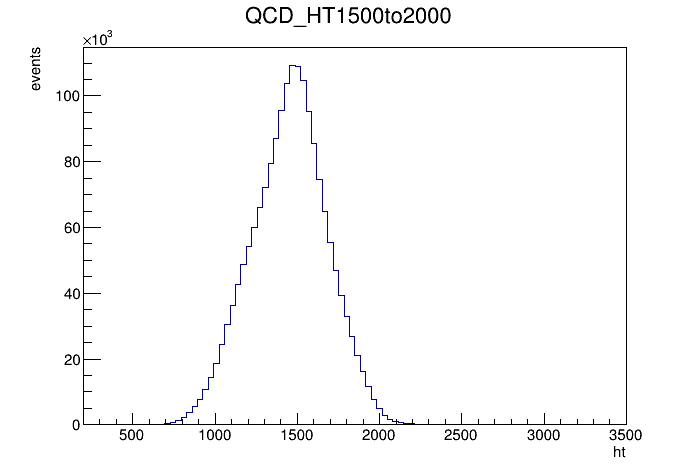

In [20]:
canv=TCanvas("canv","canv",700,500)
gPad.SetLeftMargin(0.12)
histos["QCD_HT1500to2000"]["dijetht"].SetTitle("QCD_HT1500to2000;ht;events")
histos["QCD_HT1500to2000"]["dijetht"].SetStats(0)
histos["QCD_HT1500to2000"]["dijetht"].Draw("hist")
canv.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


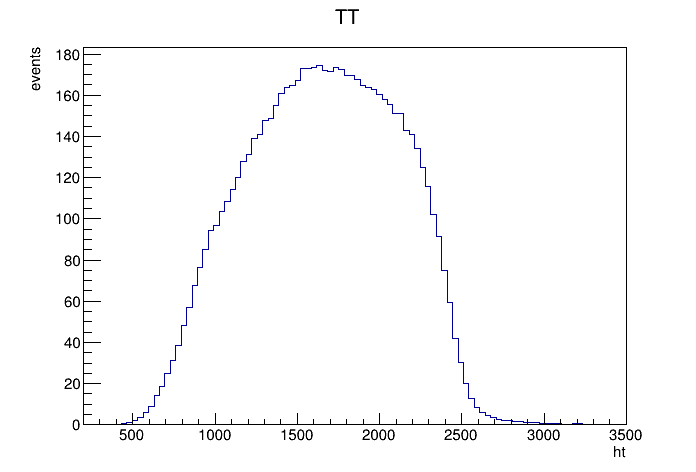

In [21]:
canv=TCanvas("canv","canv",700,500)
gPad.SetLeftMargin(0.12)
histos["TT"]["dijetht"].SetTitle("TT;ht;events")
histos["TT"]["dijetht"].SetStats(0)
histos["TT"]["dijetht"].Draw("hist")
canv.Draw()